In [1]:
import xgboost as xgb
from xgboost import XGBClassifier 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc

from sklearn.svm import SVC

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

c:\Users\Hal9\anaconda3\envs\condaPytorchEnv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Usefull Functions ###

In [2]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0,1],[0,1], color="grey", linestyle="--")
    ax.set_ylabel("TPR")
    ax.set_xlabel("FPR")
    ax.set_title(f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}")

In [3]:
def true_preds(preds, index_df):
    result =  pd.DataFrame(
        {
            "h1n1_vaccine": preds[0][:,1],
            "seasonal_vaccine": preds[1][:,1],
        },
        index=index_df
    )
    return result

In [4]:
def plot_roc_h1n1_and_seasonal(y_eval, y_preds):
    fig, ax = plt.subplots(1,2,figsize=(7, 3.5))

    plot_roc(
        y_eval["h1n1_vaccine"],
        y_preds["h1n1_vaccine"],
        "h1n1_vaccine",
        ax=ax[0]
    )

    plot_roc(
        y_eval["seasonal_vaccine"],
        y_preds["seasonal_vaccine"],
        "seasonal_vaccine",
        ax=ax[1]
    )

    fig.tight_layout()

In [40]:
def train_fullset_and_save(estimator, X_test_df, X_train_df, y_train_df,submission_data_filepath):
    submission_df = pd.read_csv("submission_format.csv", index_col="respondent_id")
    np.testing.assert_array_equal(submission_df.index.values, X_test_df.index.values)
    
    estimator.fit(X_train_df, y_train_df)
    test_preds = estimator.predict_proba(X_test_df)

    submission_df["h1n1_vaccine"]=test_preds[0][:,1]
    submission_df["seasonal_vaccine"]=test_preds[1][:,1]
    
    submission_df.to_csv(submission_data_filepath, index=True)

### Read Data, Train-Eval-Split ###

In [5]:
# read the csv-files and take the respondent_id column as index:

X_train_df = pd.read_csv("training_set_features.csv", index_col="respondent_id")
y_train_df = pd.read_csv("training_set_labels.csv", index_col="respondent_id")
X_test_df = pd.read_csv("test_set_features.csv", index_col="respondent_id")

X_train_df.shape, X_test_df.shape
# Output:
# ((26707, 36), (26708, 36))


((26707, 35), (26708, 35))

In [6]:
random_seed = 11
test_size = 0.2
X_train, X_eval, y_train, y_eval = train_test_split(X_train_df, y_train_df, test_size=test_size, random_state=random_seed)

### Data Preprocessing with Category Encoding ###

#### Category Encoding ####

In [7]:
# transform the two independent binary labels to a categorial output:

label_number_to_categories = { 0: "not vaccinated", 1: "only seasonal", 2 : "only h1n1", 3 : "seasonal and h1n1"}
label_number_to_multilabel = { 0: [0,0], 1: [0,1], 2 : [1,0], 3 : [1,1] }

def multiLableTocategory(l):
    if np.array_equal(l, [0,0]):
        return 0
    if np.array_equal(l,[0,1]):
        return 1
    if np.array_equal(l, [1,0]):
        return 2
    if np.array_equal(l, [1,1]):
        return 3

y_train_cat = [ multiLableTocategory(yt) for yt in y_train.values]
y_eval_cat = [multiLableTocategory(yt) for yt in y_eval.values]

#### Preprocessing Pipeline ####

In [8]:
num_cols = X_train_df.columns[X_train_df.dtypes != "object"].values
non_numeric_columns = X_train_df.columns[X_train_df.dtypes == "object"].values

In [9]:
# prepro pipeline:

from sklearn.model_selection import GridSearchCV


numeric_preprocessing_pipeline = Pipeline([
    ("simple_imputer", SimpleImputer(strategy="constant", fill_value=np.NaN))
])


# column transformer with only numerical columns:

preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_pipeline, num_cols),
        ("ohe_num", OneHotEncoder(), num_cols),
        ("ohe_non_num", OneHotEncoder(), non_numeric_columns)
    ],
    remainder="drop"
)


## GridSearchCV on Multiclass-Output XGBClassifier ##

##### Choose one of the Parametrizations for the XGBoost Classifier #####

In [23]:
params = {
  'colsample_bynode': 0.8,
  'learning_rate': 1,
  'max_depth': 5,
  'num_parallel_tree': 100,
  'objective': 'binary:logistic',
  'subsample': 0.8,
  'tree_method': 'gpu_hist'
}

#### GridSearchCV ####

In [42]:
gridcv_params = {
    "max_depth": [2, 4, 10 ],
    "n_estimators": [100, 200, 500],
    "eval_metric": ["auc"]

}

In [43]:

xgb_clf = XGBClassifier(use_label_encoder=False, )

gs_clf = GridSearchCV(
        xgb_clf, 
        gridcv_params,
    )

gs_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("gs_clf", gs_clf),
])


In [44]:
# training on a four-class output:

gs_pipeline.fit(X_train, y_train_cat)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=nan,
                                                                                 strategy='constant'))]),
                                                  array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       'behavioral_outside_h...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_par

In [45]:
best_params = gs_pipeline["gs_clf"].best_params_
print(best_params)

{'eval_metric': 'auc', 'max_depth': 2, 'n_estimators': 100}


### Prediction and Presentation AUC for Seasonal and H1N1 ###

In [46]:
y_preds = gs_pipeline.predict_proba(X_eval)

In [47]:
# probabilities for the four categories:
y_preds[0]

array([0.554499  , 0.3208511 , 0.04370911, 0.08094081], dtype=float32)

In [48]:
# for this task we assume, that h1n1- and seasonal-vaccination are predicted independently, i.e. the case of both vaccinations, [1,1] counts for each 
# single case i.e. [0,1] and [1,0]:

y_pred_proba_seasonal = y_preds[:,1] + y_preds[:, 3]
y_pred_proba_h1n1 = y_preds[:,2] + y_preds[:,3]

In [21]:
# peek at data-shapes:
y_eval.head(1)

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
18682,1,1


In [49]:
y_eval_seasonal = y_eval.values[:,1]
y_eval_h1n1 = y_eval.values[:,0]

In [50]:
roc_auc_score(y_eval_seasonal, y_pred_proba_seasonal), roc_auc_score(y_eval_h1n1, y_pred_proba_h1n1)

(0.8684990250275161, 0.8724147591706047)

In [53]:
type()

xgboost.sklearn.XGBClassifier

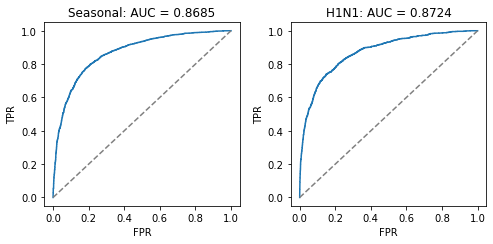

In [51]:
fig, ax = plt.subplots(1,2,figsize=(7, 3.5))
plot_roc(y_eval_seasonal, y_pred_proba_seasonal, "Seasonal", ax=ax[0])
plot_roc(y_eval_h1n1, y_pred_proba_h1n1, "H1N1", ax=ax[1])
fig.tight_layout()

### Retraining and Saving the Model ###

In [57]:
submission_data_filepath = "my_submission_multioutput_xgb_clf.csv"

y_train_df_cat = [ multiLableTocategory(yt) for yt in y_train_df.values]
gs_pipeline.fit(X_train_df, y_train_df_cat)

y_pred_test = gs_pipeline.predict_proba(X_test_df)
y_pred_proba_seasonal = y_pred_test[:,1] + y_pred_test[:, 3]
y_pred_proba_h1n1 = y_pred_test[:,2] + y_pred_test[:,3]

submission_df = pd.read_csv("submission_format.csv", index_col="respondent_id")
np.testing.assert_array_equal(submission_df.index.values, X_test_df.index.values)
submission_df["h1n1_vaccine"]=y_pred_proba_h1n1
submission_df["seasonal_vaccine"]=y_pred_proba_seasonal

submission_df.to_csv(submission_data_filepath, index=True)

## GridSearchCV on Sklearn's MultiOutputClassifier ##

Compare the run-times of this solution, where we use the Sklearn MultiOutputClassifier and apply GridSearchCV to it, with the run-times of the solution above, where we transform the multiclass-labels to four categories, train a pipeline containing a gridsearch:

Training: this = 0.8s, above = 1m53,3s

Retraining on full set: this = 1.2s , above = 2m20.5s

Maybe the gridsearch in the pipeline is time consuming and it should rather be a pipeline in the gridsearch?

In [58]:
gridcv_params = {
    "max_depth": [2, 4, 10 ],
    "n_estimators": [100, 200, 500],
    "metrics": ["auc"]
}

In [61]:
# grid-search for the multioutput-classifier as a whole:

multixgb_clf = MultiOutputClassifier(xgb_clf)

multi_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("multioutput_clf", multixgb_clf),
])

gridcv_params = {
    "multioutput_clf__estimator__max_depth": [2, 4, 10 ],
    "multioutput_clf__estimator__n_estimators": [100, 200, 500]
}

gs_clf = GridSearchCV(
        multi_pipeline, 
        gridcv_params,
    )

In [62]:
multi_pipeline.fit(X_train, y_train)

[18:04:23] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:04:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value=nan,
                                                                                 strategy='constant'))]),
                                                  array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       'behavioral_outside_h...
                                                               learning_rate=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               min_child_weight=None,
                

In [63]:
y_preds = multi_pipeline.predict_proba(X_eval)

# probabilities for the two categories:
y_preds[0]

array([[0.82150555, 0.17849442],
       [0.9953822 , 0.00461779],
       [0.52202284, 0.47797716],
       ...,
       [0.96427864, 0.03572139],
       [0.5933807 , 0.40661928],
       [0.961662  , 0.03833802]], dtype=float32)

In [64]:
# peek at data-structure:

y_eval.head(1)

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
18682,1,1


In [65]:
y_preds_true = true_preds(y_preds, y_eval.index)

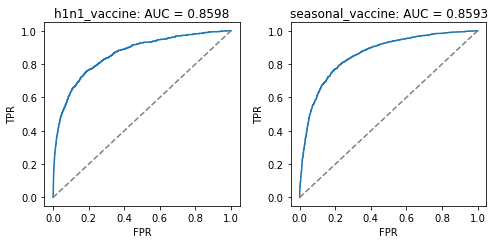

In [66]:
plot_roc_h1n1_and_seasonal(y_eval, y_preds_true)

In [68]:
# save to "my_submission_file":

my_submission_file = "my_submission_MultiOutputClassifier_xgboost.csv"

train_fullset_and_save(multi_pipeline, X_test_df, X_train_df, y_train_df, my_submission_file)

[18:10:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:10:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Documentation of dmlc XGBoost / py-xgboost(?)

https://xgboost.readthedocs.io/en/stable/python/python_intro.html#setting-parameters

In [ ]:
xgb_clf.get_params()

# output:
#{'objective': 'multi:softprob',
# 'use_label_encoder': False,
# 'base_score': 0.5,
# 'booster': 'gbtree',
# 'colsample_bylevel': 1,
# 'colsample_bynode': 1,
# 'colsample_bytree': 1,
# 'enable_categorical': False,
# 'gamma': 0,
# 'gpu_id': -1,
# 'importance_type': None,
# 'interaction_constraints': '',
# 'learning_rate': 0.300000012,
# 'max_delta_step': 0,
# 'max_depth': 6,
# 'min_child_weight': 1,
# 'missing': nan,
# 'monotone_constraints': '()',
# 'n_estimators': 100,
# 'n_jobs': 24,
# 'num_parallel_tree': 1,
# 'predictor': 'auto',
# 'random_state': 0,
# 'reg_alpha': 0,
# 'reg_lambda': 1,
# 'scale_pos_weight': None,
# 'subsample': 1,
# 'tree_method': 'exact',
# 'validate_parameters': 1,
# 'verbosity': None}